In [1]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
from qutip.ipynbtools import version_table
from tqdm.notebook import tqdm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from matplotlib.patches import Rectangle
import pandas as pd


resol = 300
pi = np.pi
version_table()

#plt.rcParams.update({
#    "text.usetex": True,
#    "font.family": "serif"
#})

Software,Version
QuTiP,5.1.1
Numpy,1.26.2
SciPy,1.11.3
matplotlib,3.7.3
Number of CPUs,11
BLAS Info,Generic
IPython,8.17.2
Python,"3.12.0 (v3.12.0:0fb18b02c8, Oct 2 2023, 09:45:56) [Clang 13.0.0 (clang-1300.0.29.30)]"
OS,posix [darwin]
Cython,3.0.11


<h1> RG Scheme </h1>

In [2]:
def update_state(c,b,gamma,omega_tab,omega_A,L,t, dt):
    """
    Update the state of the system based on the given parameters.
    
    Parameters:
    c (np array): Coefficients in front of the states |1_k, 0>
    b (float): Atomic coefficient in front of the state |0, 1>
    g_0 (float): Coupling strength.
    omega_tab (array): Array of frequencies.
    L (int): Length of the system.
    
    Returns:
    c_new (np array): Updated coefficients.
    b_new (float): Updated atomic coefficient.
    """
    g_matrix_individual = 1j * np.sqrt(gamma / (2*L)) * np.exp(-1j * (omega_tab - omega_A) * t)
    g_matrix = np.concatenate((g_matrix_individual, g_matrix_individual))

    b_new = c @ g_matrix
    c_new = b * np.conjugate(g_matrix)

    return -1j* dt * c_new, -1j * dt * b_new

def RG_scheme(c_init, b_init, gamma, omega_tab, omega_A, L, T, dt, progress_bar=True):
    """
    Propagates the state of the system using the RG scheme.
    
    Parameters:
    c_init (np array): initial coefficients in front of the states |1_k, 0>
    b_init (float): initial atomic coefficient in front of the state |0, 1>
    g_0 (float): Coupling strength.
    omega_tab (array): Array of frequencies.
    L (float): Length of the system.
    T (float): Total time for propagation.
    dt (float): Time step for propagation.
    
    Returns:
    c_array (np array): Array of c coefficients at each time step.
    b_array (np array): Array of b coefficients at each time step.
    """

    nb_pts_time = int(T / dt)
    n_modes = len(c_init)//2
    c_array = np.zeros((nb_pts_time, 2*n_modes), dtype=complex)
    b_array = np.zeros(nb_pts_time, dtype=complex)

    # Set the initial conditions
    c_array[0] = c_init
    b_array[0] = b_init

    # Time evolution loop
    for i in tqdm(range(1, nb_pts_time), disable=not progress_bar):
        t = i * dt
        c_current = c_array[i-1]
        b_current = b_array[i-1]

        c_new_k1, b_new_k1 = update_state(c_current, b_current, gamma, omega_tab, omega_A, L, t, dt)
        c_new_k2, b_new_k2 = update_state(c_current + c_new_k1/2, b_current + b_new_k1/2, gamma, omega_tab, omega_A, L, t + dt/2, dt)
        c_new_k3, b_new_k3 = update_state(c_current + c_new_k2/2, b_current + b_new_k2/2, gamma, omega_tab, omega_A, L, t + dt/2, dt)
        c_new_k4, b_new_k4 = update_state(c_current + c_new_k3, b_current + b_new_k3, gamma, omega_tab, omega_A, L, t + dt, dt)

        c_new = c_current + (c_new_k1 + 2*c_new_k2 + 2*c_new_k3 + c_new_k4) / 6
        b_new = b_current + (b_new_k1 + 2*b_new_k2 + 2*b_new_k3 + b_new_k4) / 6

        c_array[i] = c_new
        b_array[i] = b_new

    return c_array, b_array 
    

<h1> Function that treats the whole evolution </h1>

In [3]:
def get_data_mirror_fast(L, T, dt, omega_0, omega_A, omega_max, gamma, sigma, x_0, print_nb_modes = False, progress_bar=True):
    """
    Generate data for the RG scheme with a mirror.
    
    Parameters:
    L (float): Length of the system.
    T (float): Total time for propagation.
    dt (float): Time step for propagation.
    omega_0 (float): Frequency of the photon
    omega_A (float): Frequency of the atom
    omega_max (float): Maximum frequency for the modes.
    g_0 (float): Coupling strength.
    sigma (float): Width of the Gaussian wave packet in position space.
    x_0 (float): Position of the Gaussian peak.
    print_nb_modes (bool): Whether to print the number of modes used.
    
    Returns:
    c_array (np array): Coefficients in front of the states |1_k, 0>.
    b_array (np array): Coefficients in front of the state |0, 1>.
    omega_tab (np array): Array of frequencies.
    """
    
    #quantization of the modes
    omega_tab_individual = np.array([2*pi*n/L for n in range(1000000) if 2*pi*n/L <= omega_max])
    k_tab_individual = np.copy(omega_tab_individual)
    n_modes = len(k_tab_individual)

    if print_nb_modes:
        print("Number of modes: ", n_modes)
    
    #prepare the initial state
    print("Preparing the initial state...")
    c_init = np.zeros(2*n_modes, dtype=complex)
    b_init = 0

    c_init_1 = np.exp(-(0.5*(k_tab_individual - omega_0)**2) * sigma**2) * np.exp(-1j * k_tab_individual * x_0)
    c_init = np.concatenate((c_init_1, np.zeros(n_modes))) #only one photon in the first channel
    c_init /= np.sqrt(np.sum(np.abs(c_init)**2))  # Normalize the initial state

    ##evolve the state
    print("Evolving the state...")
    c_array, b_array = RG_scheme(c_init, b_init, gamma, omega_tab_individual, omega_A, L, T, dt, progress_bar=progress_bar)


    return c_array, b_array, k_tab_individual

###For comparison with ED

def get_data_mirror_ed(L, T, dt, omega_0, omega_A, omega_max, gamma, sigma, x_0, print_nb_modes = False):
    #quantization of the modes
    omega_tab_individual = np.array([2*pi*n/L for n in range(1000000) if 2*pi*n/L <= omega_max])
    k_tab_individual = np.copy(omega_tab_individual)
    n_modes = len(k_tab_individual)

    if print_nb_modes:
        print("Number of modes: ", n_modes)

    #Creation of the Hamiltonian
    dim_subspace = 2*n_modes + 1
    H_matrix = np.zeros((dim_subspace, dim_subspace), dtype=complex)

    print("Preparing the Hamiltonian ...")
    for i in range(n_modes):

        #diagonal elements
        H_matrix[i, i] = omega_tab_individual[i]
        H_matrix[i+n_modes, i+n_modes] = omega_tab_individual[i]

        #off diagonal elements
        H_matrix[2*n_modes,i] = 1j*np.sqrt(gamma/(2*L))
        H_matrix[2*n_modes, i+n_modes] = 1j*np.sqrt(gamma/(2*L))

        H_matrix[i,2*n_modes] = -1j*np.sqrt(gamma/(2*L))
        H_matrix[i+n_modes, 2*n_modes] = -1j*np.sqrt(gamma/(2*L))

    H_matrix[2*n_modes, 2*n_modes] = omega_A

    H = qt.Qobj(H_matrix)
    #hermicity check
    if not H.isherm:
        print("Hermicity of the Hamiltonian: ", H.isherm)
        return None

    print("Initializing the state ...")
    ##Initial state

    init_state = 0
    for i in range(n_modes): ##only the modes in the first waveguide
        coef = np.exp(-0.5*sigma**2*(k_tab_individual[i] - omega_0)**2 -1j * k_tab_individual[i] * x_0)
        init_state += coef * qt.basis(dim_subspace, i)
    init_state = init_state.unit()
    
    print("Launching the time evolution ...")
    #time evolution
    n_step = int(T/dt)
    times = np.linspace(0, T, n_step)
    result = qt.sesolve(H, init_state, times, options={"nsteps":10000, "progress_bar": True, "store_states": True})
    state_list = result.states
    
    return times, state_list

<h1> First test </h1>

Generate an example

In [115]:
L = 50*pi
T = L/2
dt = 0.01

#Bare parameters
gamma = 1
omega_A = 5
omega_max = 15

#renormalized frequency
omega_A_phys = omega_A - gamma/(2*pi) * np.log((omega_max-omega_A)/omega_A)

#initial photonic wave packet
omega_0 = omega_A_phys - gamma/2
sigma = L/8
sigma_momentum = 1/sigma
x_0 = -L/4

#check some parameters
print("50% Reflectivity for omega_0_m = ", omega_A_phys - gamma, " and omega_0_p = ", omega_A_phys + gamma)
print("Value of gamma", gamma, "and sigma_momentum = ", sigma_momentum)

#save the parameters
save_param = False

if save_param:
    data = {
        'L' : L,
        'gamma': gamma,
        'dt': dt,
        'omega_A': omega_A,
        'omega_0': omega_0,
        'omega_max': omega_max,
        'sigma': sigma
    }
    df = pd.DataFrame(data, index=[0])
    current_filename = f"callibration_example_param.csv"
    df.to_csv(current_filename, index=False)

50% Reflectivity for omega_0_m =  3.8896821999236746  and omega_0_p =  5.889682199923675
Value of gamma 1 and sigma_momentum =  0.05092958178940651


In [116]:
recover_example = False

if recover_example:
    param_file = f"callibration_example_param.csv"
    df = pd.read_csv(param_file)

    L = df['L'][0]
    T = L/2
    dt = df['dt'][0]
    omega_0 = df['omega_0'][0]
    omega_A = df['omega_A'][0]
    omega_max = df['omega_max'][0]
    gamma = df['gamma'][0]
    sigma = df['sigma'][0]
    x_0 = -L/4

c_array, b_array, k_tab = get_data_mirror_fast(L, T, dt, omega_0, omega_A, omega_max, gamma, sigma, x_0, print_nb_modes=True)

#ED comparision
ed = False

if ed:
    dt_ed = 0.01
    print("Exact diagonalization...")
    times_ed, state_list_ed = get_data_mirror_ed(L, T, dt_ed, omega_0, omega_A, omega_max, gamma, sigma, x_0, print_nb_modes = True)

Number of modes:  376
Preparing the initial state...
Evolving the state...


  0%|          | 0/7852 [00:00<?, ?it/s]

<h1> Occupation numbers </h1>

In [117]:
time_array = np.linspace(0, T, int(T / dt))
# Prepare the k_tab for occupation numbers
n_modes = c_array.shape[1] //2
nb_pts_time = int(T / dt)

p_1 = np.zeros(nb_pts_time)
p_2 = np.zeros(nb_pts_time)
p_atom =  np.zeros(nb_pts_time)

for i in tqdm(range(nb_pts_time)):
    p_1[i] = np.sum(np.abs(c_array[i,:n_modes])**2)
    p_2[i] = np.sum(np.abs(c_array[i,n_modes:])**2)
    p_atom[i] = np.abs(b_array[i])**2  

#comparing with ed
if ed:
    nb_pts_time_ed = len(times_ed)
    p_1_ed = np.zeros(nb_pts_time_ed)
    p_2_ed = np.zeros(nb_pts_time_ed)
    p_atom_ed =  np.zeros(nb_pts_time_ed)

    for i in tqdm(range(nb_pts_time_ed)):
        current_state = state_list_ed[i].full().reshape(2*n_modes+1)
        p_1_ed[i] = np.sum(np.abs(current_state[:n_modes]**2))
        p_2_ed[i] = np.sum(np.abs(current_state[n_modes:2*n_modes]**2))
        p_atom_ed[i] = np.abs(current_state[2*n_modes]**2)    
    

  0%|          | 0/7853 [00:00<?, ?it/s]

Reflection probability = 0.5296247054405142
Final atom's excitation probability:  0.0006879965511995545


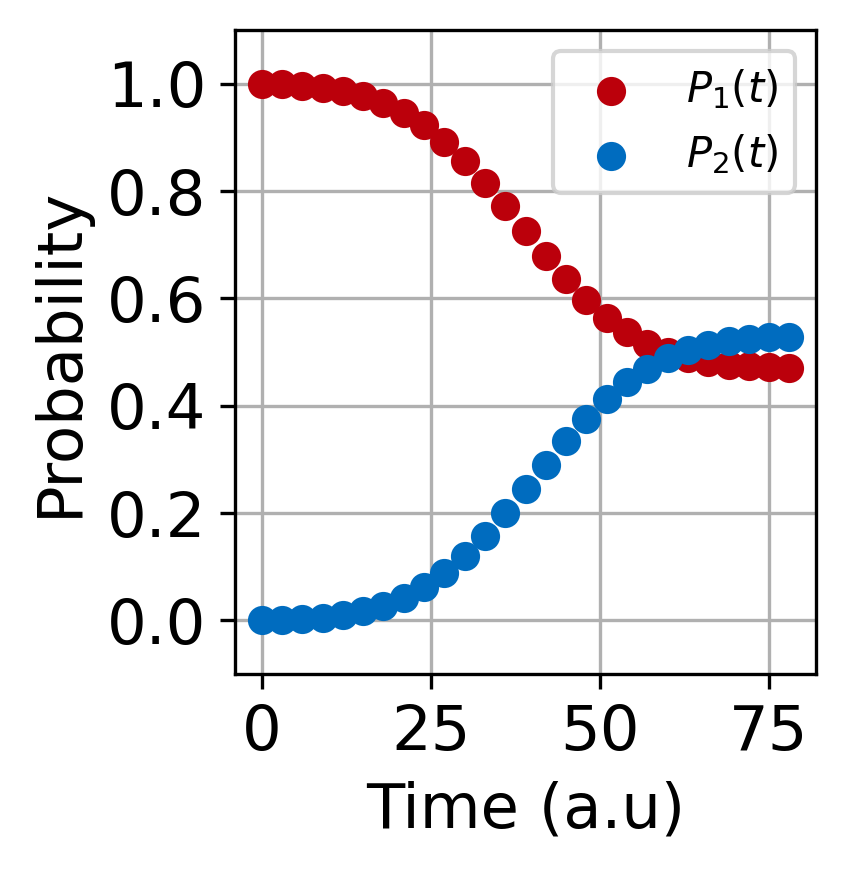

In [118]:
print("Reflection probability =", 1-p_1[-1])
print("Final atom's excitation probability: ", 1-p_1[-1]-p_2[-1])

fig, ax = plt.subplots(1,1, figsize=(3,3), dpi=resol)

step_to_show = 300

ax.scatter(time_array[::step_to_show], p_1[::step_to_show], label=r'$P_1(t)$', color='#bb000b', zorder = 1)
ax.scatter(time_array[::step_to_show], p_2[::step_to_show], label=r'$P_2(t)$', color='#006cbf', zorder=1)

if ed:
    ax.plot(times_ed, p_1_ed, color='#6d0303', alpha=0.6, zorder = -1)
    ax.plot(times_ed, p_2_ed,color='#1c556d', alpha=0.6, zorder = -1)

ax.set_xlabel('Time (a.u)')
ax.set_ylabel('Probability')
ax.set_ylim(-0.1,1.1)
ax.legend(prop={'size': 10})

#font size
for item in [ax.xaxis.label, ax.yaxis.label]:
    item.set_fontsize(15)

for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)


ax.grid()
ax.set_axisbelow(True)  

plt.tight_layout()
#plt.savefig("./fig/one_photon_ex_p1p2.pdf")
plt.show()

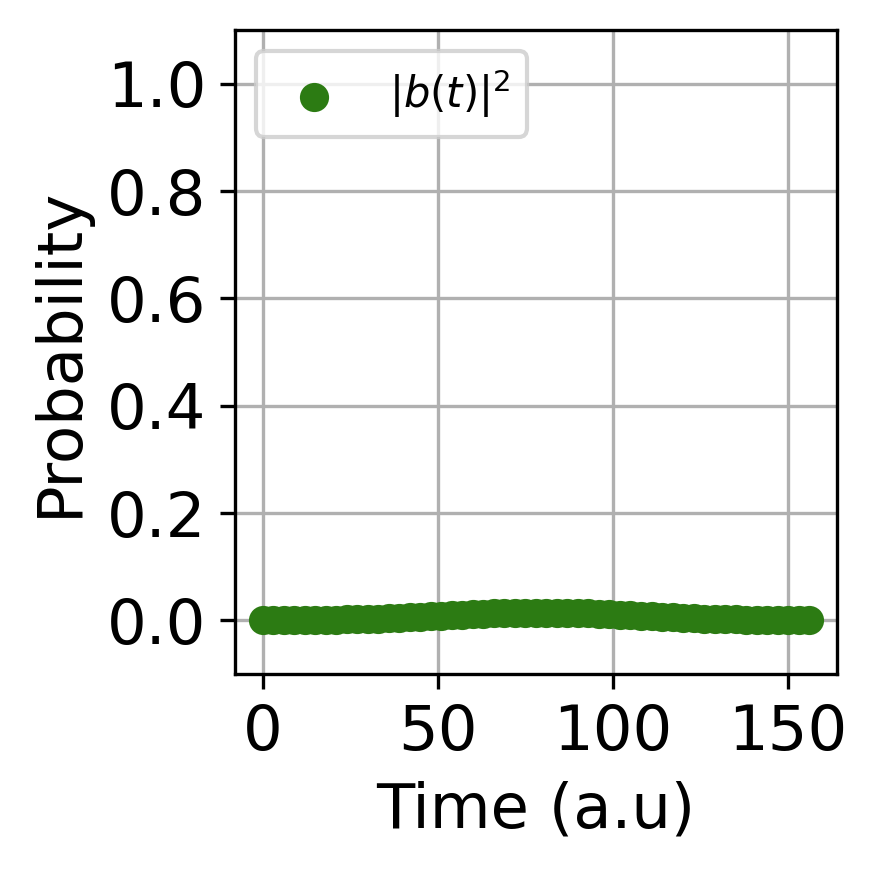

In [75]:
fig, ax = plt.subplots(1,1, figsize=(3,3), dpi=resol)

step_to_show = 300
ax.scatter(time_array[::step_to_show], p_atom[::step_to_show], label=r'$|b(t)|^2$', color='#2c7b13')   
ax.plot(times_ed, p_atom_ed,color='#174708', alpha=0.6, zorder=-1) 


#ax.set_ylim(-0.1,1.1)
ax.set_xlabel('Time (a.u)')
ax.set_ylabel('Probability')

#font size
for item in [ax.xaxis.label, ax.yaxis.label]:
    item.set_fontsize(15)

for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)


ax.grid()
ax.set_axisbelow(True)  
ax.set_ylim(-0.1,1.1)


# Create an inset axes [x0, y0, width, height] in axes coordinates
#axins = inset_axes(ax, width="40%", height="40%", loc='upper right')

# Zoom range near zero
#axins.scatter(time_array[::step_to_show], p_atom[::step_to_show], color='#2c7b13')   
#axins.plot(times_ed, p_atom_ed,color='#174708', alpha=0.6, zorder=-1) 
#axins.set_xlim(L/8, 3*L/8)
#axins.set_ylim(-0.01, 0.04)  # slightly higher for clarity
#axins.grid()

#rect = Rectangle((L/8, -0.03), L/4, 0.1, linewidth=1, edgecolor='black', linestyle='--', facecolor='none')
#ax.add_patch(rect)
#ax.plot([L/8, 1.15*L/4], [0.07, 0.58], '--', color='black', lw=0.8)
#ax.plot([3*L/8, 1.37*3*L/8], [0.07, 0.58], '--', color='black', lw=0.8)

ax.legend(prop={'size': 10}, loc="upper left")

plt.tight_layout()
#plt.savefig("./fig/one_photon_ex_b.pdf")
plt.show()

<h1> Reflection against detunning </h1>

In [86]:
L = 30*pi
T = L/2
dt = 0.01

#Jaynes-Cummings parameter g_0 and energies 
gamma = 1
omega_A = 10
omega_max = 40
print("Omega_max = ", omega_max)

#initial photon wavepacket parameters
sigma = L/8
sigma_momentum = 1/sigma
x_0 = -L/4

print("50% Reflectivity for omega_0_m = ", omega_A - gamma, " and omega_0_p = ", omega_A + gamma)
print("Value of sigma ", sigma, " and life time of the excited state: ", 1/gamma)


Omega_max =  40
50% Reflectivity for omega_0_m =  9  and omega_0_p =  11
Value of sigma  11.780972450961723  and life time of the excited state:  1.0


Run the calculations

In [87]:
#get the number of modes
nb_freq = 39

omega_0_tab = np.linspace(max(omega_A - gamma, 0), min(omega_A + gamma, 0.8*omega_max), nb_freq)
#omega_0_tab = [1]
p_1_tab = np.zeros(nb_freq)

for i in tqdm(range(nb_freq)):
    omega_0 = omega_0_tab[i]
    print(f"Running for omega_0 = {omega_0}")
    c_array, b_array, k_tab = get_data_mirror_fast(L, T, dt, omega_0, omega_A, omega_max, gamma, sigma, x_0, print_nb_modes=False, progress_bar=False)
    n_modes = len(k_tab)
    p_1_tab[i] = np.sum(np.abs(c_array[-1, :n_modes])**2) 

  0%|          | 0/39 [00:00<?, ?it/s]

Running for omega_0 = 9.0
Preparing the initial state...
Evolving the state...
Running for omega_0 = 9.052631578947368
Preparing the initial state...
Evolving the state...
Running for omega_0 = 9.105263157894736
Preparing the initial state...
Evolving the state...
Running for omega_0 = 9.157894736842104
Preparing the initial state...
Evolving the state...
Running for omega_0 = 9.210526315789474
Preparing the initial state...
Evolving the state...
Running for omega_0 = 9.263157894736842
Preparing the initial state...
Evolving the state...
Running for omega_0 = 9.31578947368421
Preparing the initial state...
Evolving the state...
Running for omega_0 = 9.368421052631579
Preparing the initial state...
Evolving the state...
Running for omega_0 = 9.421052631578947
Preparing the initial state...
Evolving the state...
Running for omega_0 = 9.473684210526315
Preparing the initial state...
Evolving the state...
Running for omega_0 = 9.526315789473685
Preparing the initial state...
Evolving the s

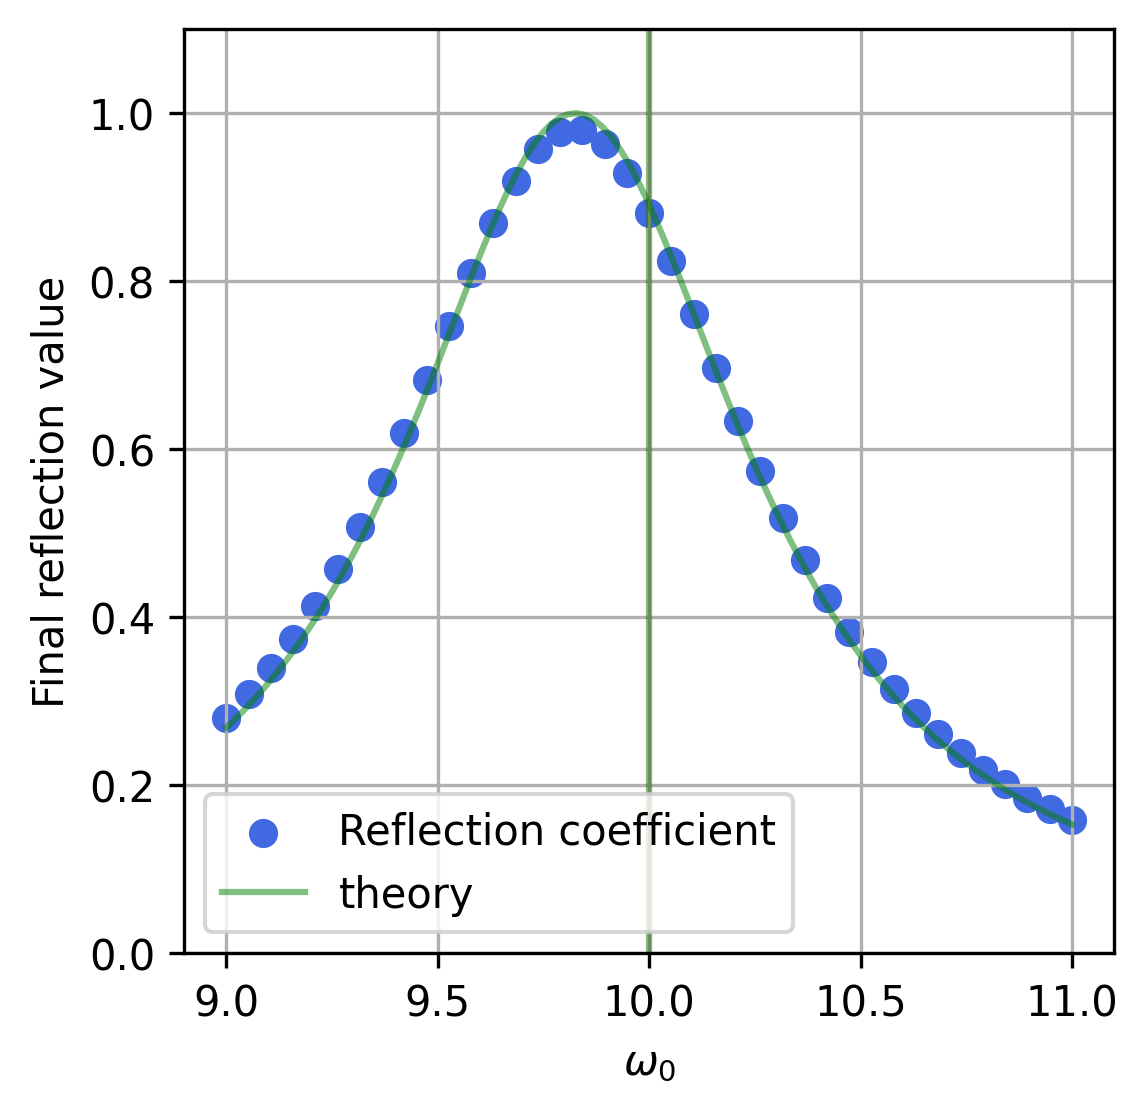

In [88]:
#theory_guess
omega_0_tab_theory = np.linspace(max(omega_A - gamma, 0), omega_A + gamma, 100)
omega_A_phys = omega_A - gamma / (2*pi) * np.log((omega_max-omega_A)/omega_A)
gamma_phys = gamma 
theory_curve = 1 / (1 + (omega_0_tab_theory - omega_A_phys)**2 / (gamma_phys/2)**2)


fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=resol)
ax.scatter(omega_0_tab, 1-p_1_tab, marker='o', color="royalblue", label='Reflection coefficient')
ax.plot(omega_0_tab_theory, theory_curve, color="green", alpha=0.5, label="theory")
ax.legend()
ax.set_xlabel(r'$\omega_0$')
ax.set_ylabel('Final reflection value')
ax.vlines(omega_A, 0, 3, color='#246d11', alpha=0.5, label=r'$\omega_A$')
ax.set_ylim(0, 1.1)
ax.grid()
plt.show()

Sanity check

In [22]:
reflection_50_index = np.argmin(np.abs(omega_0_tab - (omega_A_phys - gamma/2)))
print(1-p_1_tab[reflection_50_index])

0.49510280518730654
